In [1]:
import numpy as np
import dask.array as da
from dask_ml.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from dask_ml.decomposition import IncrementalPCA
from dask_ml.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    GenericTransformer,
    solve_fe
)

from toolz.curried import curry, pipe, valmap, itemmap, iterate, do,merge_with
from toolz.curried import map as map_
from modAL.models import ActiveLearner, CommitteeRegressor, BayesianOptimizer
from modAL.disagreement import max_std_sampling
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
import tqdm
import types
from pymks.fmks.func import sequence

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("PCAdata.csv")


In [4]:
data


,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,stiffness_value
0,0,-22.293185,-1.589208,0.379430,-0.054407,0.126852,0.038360,0.117163,-0.357830,-0.526625,-0.419366,-0.261920,-0.106686,-0.016246,-0.011767,0.017419,81.795324
1,1,-21.826976,-1.611240,0.372936,-0.066731,0.140262,0.041877,0.122650,-0.324201,-0.534882,-0.383974,-0.238986,-0.094505,-0.021561,-0.026448,0.002441,78.729488
2,2,-21.282932,-1.594592,0.366525,-0.043383,0.108433,0.024041,0.127364,-0.343214,-0.542392,-0.420696,-0.220706,-0.093821,-0.030854,-0.020879,0.018773,75.585195
3,3,-20.712598,-1.571126,0.379425,-0.030608,0.117497,0.016603,0.137658,-0.352097,-0.536367,-0.429227,-0.238656,-0.098354,-0.026359,-0.011161,0.007012,73.451148
4,4,-20.184583,-1.596871,0.368008,-0.024169,0.111084,-0.002232,0.136348,-0.350080,-0.520184,-0.441234,-0.200832,-0.113327,0.014005,-0.032247,0.017293,71.009709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8895,8895,29.880704,0.736584,0.645790,-0.576297,-0.455430,0.373146,0.384875,0.882042,-0.941266,-0.235289,-0.408481,0.021070,-0.164365,0.139145,0.246739,16.151469
8896,8896,30.223645,0.675952,-0.074842,-0.094698,0.129163,0.142182,0.639107,-0.883034,-0.129872,0.208893,-0.416202,0.017984,-0.002889,0.072030,-0.014023,7.057178
8897,8897,31.695787,0.512326,0.523954,0.358369,-0.323676,-0.220157,0.627902,0.434747,-0.243073,-0.762313,-0.326525,-0.339701,-0.259910,-0.150764,0.032238,18.006485
8898,8898,29.576089,0.756499,0.035908,0.038147,-0.012801,0.003112,-0.225163,-0.024374,0.126842,-0.852435,-0.073231,-0.244730,-0.050779,0.002230,-0.034798,9.001561


In [5]:
val = 6
x_data = data.iloc[:,1:val].to_numpy()

In [6]:
y_data = data.iloc[:,-1].to_numpy()

In [7]:
# def split_on_ids(arr, ids):
#     mask = np.zeros(len(arr), dtype=bool)
#     mask[ids] = True
#     return arr[mask], arr[~mask]
    
# def calc_distances(d0, d1):
#     return np.linalg.norm(d0[:, None, :] - d1[None, :, :], ord=2, axis=-1)

# def next_sample(labeled_samples, scores):
#     scores_labeled, scores_unlabeled = split_on_ids(scores, labeled_samples)
#     _, unlabeled_ids = split_on_ids(np.arange(len(scores)), labeled_samples)
#     if len(scores_labeled) == 0:
#         scores_labeled = np.mean(scores_unlabeled, axis=0)[None]
#     distances_nk = calc_distances(scores_unlabeled, scores_labeled)
#     distances_n = np.min(distances_nk, axis=1)
#     return unlabeled_ids[np.argmax(distances_n)]
                                         
# def gsx_query(model, x_pool):
#     if not hasattr(model, 'gsx_data'):
#         model.gsx_data = [],(x_pool)
#     labeled_samples, scores = model.gsx_data
#     next_id = next_sample(labeled_samples, scores)
#     model.gsx_data = (labeled_samples + [next_id], scores)
#     return next_id, x_pool[next_id]

# def gsy_query(model, x_pool):
#     if not hasattr(model, 'labeled_samples'):
#         model.labeled_samples = []
#     y_pool = model.predict(x_pool)
#     next_id = next_sample(model.labeled_samples, y_pool.reshape(-1, 1))
#     model.labeled_samples = model.labeled_samples + [next_id]
#     return next_id, x_pool[next_id]




query_std = lambda model, x_: pipe(
    model.predict(x_, return_std=True)[1],
    np.argmax,
    lambda i: (i, x_[i])
)


query_random = lambda model, x_: pipe(
    np.random.randint(0, len(x_)),
    lambda i: (i, x_[i])
)

In [8]:
def split_on_ids(arr, ids):
    mask = np.zeros(len(arr), dtype=bool)
    mask[ids] = True
    return arr[mask], arr[~mask]
    
def calc_distances(d0, d1):
    return np.linalg.norm(d0[:, None, :] - d1[None, :, :], ord=2, axis=-1)

def calc_distances_nk(labeled_samples, scores):
    scores_labeled, scores_unlabeled = split_on_ids(scores, labeled_samples)
    if len(scores_labeled) == 0:
        scores_labeled = np.mean(scores_unlabeled, axis=0)[None]
    return calc_distances(scores_unlabeled, scores_labeled)

def next_sample(distances_nk, labeled_samples, scores):
    distances_n = np.min(distances_nk, axis=1)
    _, unlabeled_ids = split_on_ids(np.arange(len(scores)), labeled_samples)
    return unlabeled_ids[np.argmax(distances_n)]

def next_sample_gsx(labeled_samples, scores):
    distances_nk = calc_distances_nk(labeled_samples, scores)
    return next_sample(distances_nk, labeled_samples, scores)
        
def next_sample_igs(labeled_samples, scores):
    x_scores, y_scores = scores
    distances_nk_x = calc_distances_nk(labeled_samples, x_scores)
    distances_nk_y = calc_distances_nk(labeled_samples, y_scores)
    return next_sample(distances_nk_x * distances_nk_y, labeled_samples, x_scores)

def query_helper(model, x_pool, init_scores, update_scores, next_func):
    if not hasattr(model, 'query_data'):
        model.query_data = [], init_scores()
    labeled_samples, scores = model.query_data
    scores = update_scores(model, scores)
    next_id = next_func(labeled_samples, scores)
    model.query_data = (labeled_samples + [next_id], scores)
#     print(x_pool.shape)
    return next_id, x_pool[next_id]

def gsx_query(model, x_pool):
    return query_helper(
        model,
        x_pool,
        lambda: x_pool,
        lambda m, s: s,
        next_sample_gsx
    )

def gsy_query(model, x_pool):
    return query_helper(
        model,
        x_pool,
        lambda: None,
        lambda m, s: m.predict(x_pool).reshape(-1, 1),
        next_sample_gsx
    )

def igs_query(model, x_pool):
    return query_helper(
        model,
        x_pool,
        lambda: (x_pool, None),
        lambda m, s: (s[0], m.predict(x_pool).reshape(-1, 1)),
        next_sample_igs
    )

In [9]:
n_initial = 100
state = 88
Test_sizee = 0.3
n_queries=50


# Active learning _ STD

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

In [11]:
# Define the active Learner


def make_regressor():
    kernel = Matern(length_scale=1.0)
    regressor = GaussianProcessRegressor(kernel=kernel)
    return regressor



In [12]:
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Test_sizee, random_state=state)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)


In [13]:
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

In [14]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

learner = ActiveLearner(
    estimator=make_regressor(),
    query_strategy=query_std,
    X_training=X_initial, y_training=y_initial
)

In [15]:
accuracy_scores_std = [learner.score(X_test, y_test)]

In [16]:
for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    learner.teach(X_pool[query_idx].reshape(1,val-1), y_pool[query_idx].reshape(1,))
#     X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores_std.append(learner.score(X_test, y_test))



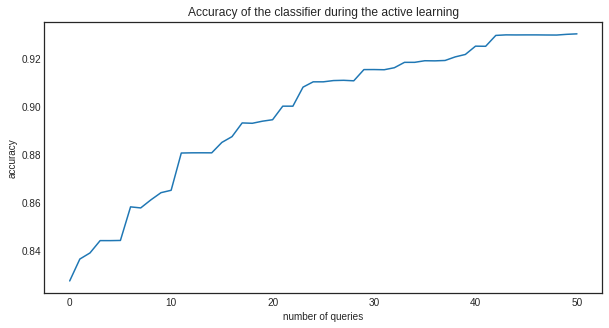

In [17]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores_std)
#     plt.scatter(range(n_queries+1), accuracy_scores_rnd)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

# Active learning _ Random

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Test_sizee, random_state=state)

In [19]:
np.random.seed(1234)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
learner = ActiveLearner(
    estimator=make_regressor(),
    query_strategy=query_random,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores_rnd = [learner.score(X_test, y_test)]
for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    learner.teach(X_pool[query_idx].reshape(1,val-1), y_pool[query_idx].reshape(1,))
#     X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores_rnd.append(learner.score(X_test, y_test))


# Active learning _ GSX


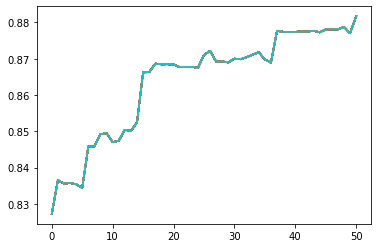

In [20]:
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Test_sizee, random_state=state)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
learner = ActiveLearner(
    estimator=make_regressor(),
    query_strategy=gsx_query,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores_gsx = [learner.score(X_test, y_test)]

for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    learner.teach(X_pool[query_idx].reshape(1,val-1), y_pool[query_idx].reshape(1,))
#     X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores_gsx.append(learner.score(X_test, y_test))
    plt.plot(range(n_queries+1), accuracy_scores_rnd)

# Active learning _ GSy


In [21]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Test_sizee, random_state=state)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)


X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
learner = ActiveLearner(
    estimator=make_regressor(),
    query_strategy=gsy_query,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores_gsy = [learner.score(X_test, y_test)]

for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    learner.teach(X_pool[query_idx].reshape(1,val-1), y_pool[query_idx].reshape(1,))
#     X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores_gsy.append(learner.score(X_test, y_test))
#     plt.plot(range(n_queries+1), accuracy_scores_rnd)

# Active learning _ iGS


In [22]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Test_sizee, random_state=state)
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)


X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
learner = ActiveLearner(
    estimator=make_regressor(),
    query_strategy=igs_query,
    X_training=X_initial, y_training=y_initial
)
accuracy_scores_igs = [learner.score(X_test, y_test)]

for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    learner.teach(X_pool[query_idx].reshape(1,val-1), y_pool[query_idx].reshape(1,))
#     X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores_igs.append(learner.score(X_test, y_test))
#     plt.plot(range(n_queries+1), accuracy_scores_rnd)

# Final Plot

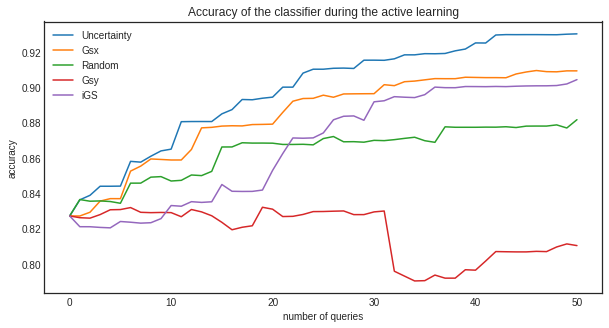

In [23]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores_std,label="Uncertainty")
    plt.plot(range(n_queries+1), accuracy_scores_gsx,label="Gsx")
    plt.plot(range(n_queries+1), accuracy_scores_rnd,label="Random")
    plt.plot(range(n_queries+1), accuracy_scores_gsy,label="Gsy")
    plt.plot(range(n_queries+1), accuracy_scores_igs,label="iGS")
    plt.legend()
    
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()